In [1]:

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

import os
import numpy as np


data_dir = '/kaggle/input/flower-dataset/dataset'

classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
counts = {c: len([f for f in os.listdir(os.path.join(data_dir, c)) if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.gif'))]) for c in classes}

print('Number of classes:', len(classes))
for c in classes:
    print(f'{c}: {counts[c]} images')

2025-11-23 05:57:41.380599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763877461.582742      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763877461.635932      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Number of classes: 5
daisy: 501 images
dandelion: 646 images
roses: 497 images
sunflowers: 495 images
tulips: 607 images


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
num_classes = len(classes)

In [8]:

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

valtest_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.30,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

valtest_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
test_batches = valtest_batches // 3
test_ds = valtest_ds.take(test_batches)
val_ds = valtest_ds.skip(test_batches)


Found 2746 files belonging to 5 classes.
Using 1923 files for training.
Found 2746 files belonging to 5 classes.
Using 823 files for validation.


In [9]:
# ( augmentations + normalization)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


rescale = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


In [10]:
def plot_metrics(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{name} Loss')
    plt.legend()
    plt.show()

In [11]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',          
        patience=5,                  
        restore_best_weights=True    
    ),
    ModelCheckpoint(
        filepath="best_weights_{epoch:02d}_{val_accuracy:.2f}.keras", 
        monitor='val_accuracy',      
        save_best_only=True,         
        mode='max',                  
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',         
        factor=0.2,                  
        patience=5,                 
        min_lr=1e-6,               
        verbose=1
    )
]

 # ALEXNET
 

In [11]:
#  ALEXNET 
model_alex = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_alex.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history_alex = model_alex.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


I0000 00:00:1762880583.531633     124 service.cc:148] XLA service 0x791568004940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762880583.532447     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762880583.532472     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762880583.935988     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/61 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2257 - loss: 1.6135

I0000 00:00:1762880589.264378     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2784 - loss: 1.5369
Epoch 1: val_accuracy improved from -inf to 0.41975, saving model to best_weights_01_0.42.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - accuracy: 0.2792 - loss: 1.5356 - val_accuracy: 0.4198 - val_loss: 1.3421 - learning_rate: 1.0000e-04
Epoch 2/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.4719 - loss: 1.2068
Epoch 2: val_accuracy improved from 0.41975 to 0.55908, saving model to best_weights_02_0.56.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 376ms/step - accuracy: 0.4725 - loss: 1.2058 - val_accuracy: 0.5591 - val_loss: 1.0349 - learning_rate: 1.0000e-04
Epoch 3/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.5388 - loss: 1.0801
Epoch 3: val_accuracy improved from 0.55908 to 0.58025, saving model to best_weights_03_0.58.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 379ms/step - accuracy: 0.5386 - loss: 1.0808 - val_accuracy: 0.5802 - val_loss: 1.0403 - learning_rate: 1.0000e-04
Epoch 4/30
60/61 ━━━━

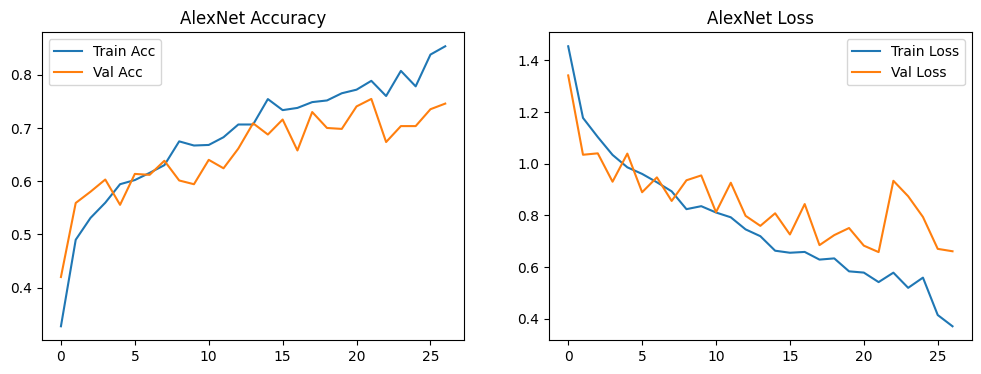

In [12]:
plot_metrics(history_alex, "AlexNet")

In [13]:
test_loss, test_acc = model_alex.evaluate(test_ds)

print(f"AlexNet Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7731 - loss: 0.6866
AlexNet Test Accuracy: 75.00%


# VGG16

In [14]:
# ---------- VGG16 ----------
model_vgg16 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg16.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)



Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.2373 - loss: 1.5913
Epoch 1: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2376 - loss: 1.5912 - val_accuracy: 0.2522 - val_loss: 1.6031 - learning_rate: 1.0000e-04
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.2274 - loss: 1.6061
Epoch 2: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 36s 585ms/step - accuracy: 0.2276 - loss: 1.6059 - val_accuracy: 0.3457 - val_loss: 1.8559 - learning_rate: 1.0000e-04
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3244 - loss: 1.4962
Epoch 3: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 596ms/step - accuracy: 0.3250 - loss: 1.4950 - val_accuracy: 0.4215 - val_loss: 1.3646 - learning_rate: 1.0000e-04
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3510 - loss: 1.3551
Epoch 4: val_accuracy did not improve from 0.75485
61/61 ━━━━━━━━━━

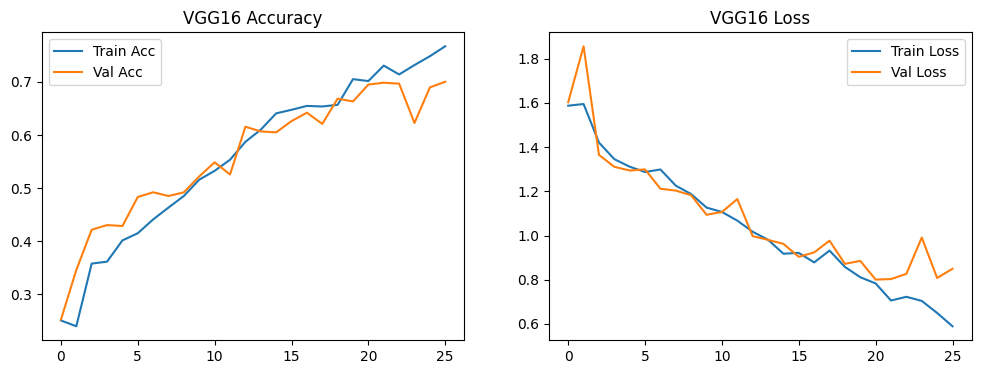

In [15]:
plot_metrics(history_vgg16, "VGG16")


In [16]:
test_loss, test_acc = model_vgg16.evaluate(test_ds)
print(f"VGG16 Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.6768 - loss: 0.7639
VGG16 Test Accuracy: 65.62%


# VGG19

In [7]:
model_vgg19 = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Block 5
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Classifier
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),              
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),               
    layers.Dense(num_classes, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=1e-5)   

model_vgg19.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_vgg19 = model_vgg19.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30


I0000 00:00:1763494023.153316     116 service.cc:148] XLA service 0x7a08c40209f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763494023.154016     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763494023.154041     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763494024.013261     116 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763494057.674396     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.2098 - loss: 1.6092
Epoch 1: val_accuracy improved from -inf to 0.22928, saving model to best_weights_01_0.23.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.2100 - loss: 1.6092 - val_accuracy: 0.2293 - val_loss: 1.6020 - learning_rate: 1.0000e-05
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.2332 - loss: 1.5990
Epoch 2: val_accuracy improved from 0.22928 to 0.27866, saving model to best_weights_02_0.28.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 863ms/step - accuracy: 0.2331 - loss: 1.5989 - val_accuracy: 0.2787 - val_loss: 1.5407 - learning_rate: 1.0000e-05
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.2911 - loss: 1.5305
Epoch 3: val_accuracy improved from 0.27866 to 0.32099, saving model to best_weights_03_0.32.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 52s 853ms/step - accuracy: 0.2912 - loss: 1.5305 - val_accuracy: 0.3210 - val_loss: 1.4775 - learning_rate: 1.0000e-05
Epoch 4/30
61/61 ━━━━━━

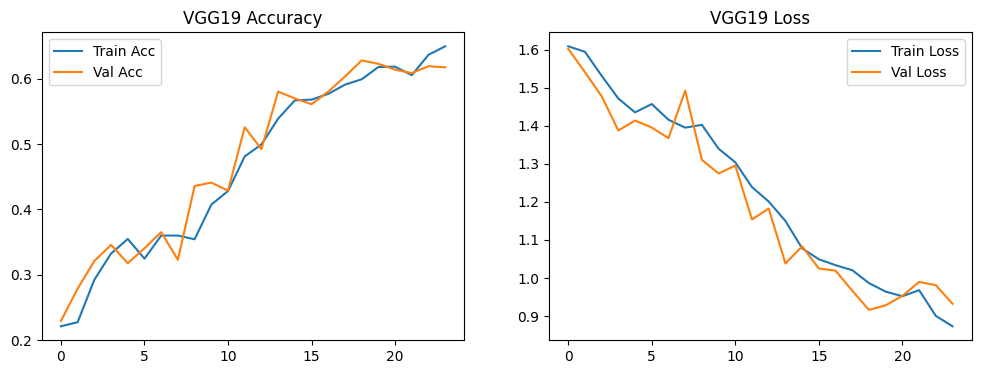

In [8]:
plot_metrics(history_vgg19, "VGG19")


In [9]:
test_loss, test_acc = model_vgg19.evaluate(test_ds)
print(f"VGG19 Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.6348 - loss: 0.9275
VGG19 Test Accuracy: 62.50%


# GOOGLENET

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.2460 - loss: 1.5994
Epoch 1: val_accuracy did not improve from 0.63845
61/61 ━━━━━━━━━━━━━━━━━━━━ 37s 443ms/step - accuracy: 0.2465 - loss: 1.5991 - val_accuracy: 0.3616 - val_loss: 1.4701 - learning_rate: 1.0000e-04
Epoch 2/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.3869 - loss: 1.3840
Epoch 2: val_accuracy did not improve from 0.63845
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 342ms/step - accuracy: 0.3878 - loss: 1.3820 - val_accuracy: 0.4515 - val_loss: 1.2037 - learning_rate: 1.0000e-04
Epoch 3/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4495 - loss: 1.2474
Epoch 3: val_accuracy did not improve from 0.63845
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.4497 - loss: 1.2472 - val_accuracy: 0.4832 - val_loss: 1.1976 - learning_rate: 1.0000e-04
Epoch 4/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4928 - loss: 1.2046
Epoch 4: val_accuracy did not improve from 0.63845
61/61 ━━━━━━━━

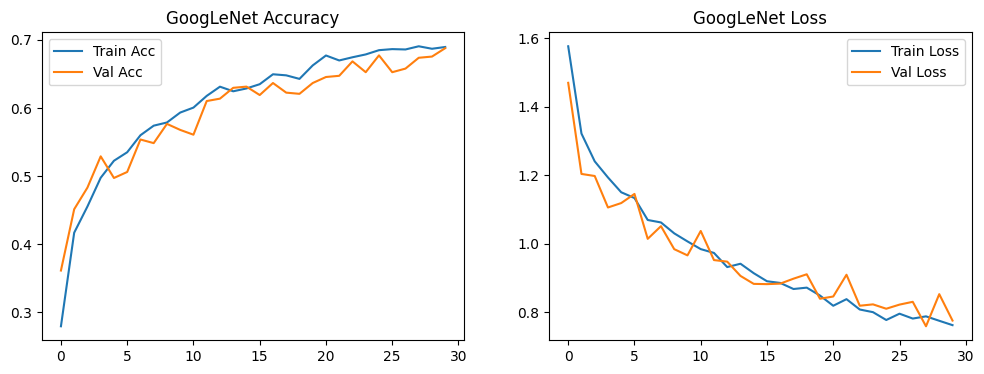

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6639 - loss: 0.8249
GoogLeNet Test Accuracy: 69.92%


In [13]:

# ---------- TASK 1.4: GOOGLENET (Inception v1) ----------

def inception_module(x, f1, f3_r, f3, f5_r, f5, proj):
  
    # Path 1: 1x1 Conv
    path1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

    # Path 2: 1x1 Conv -> 3x3 Conv
    path2 = layers.Conv2D(f3_r, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(path2)

    # Path 3: 1x1 Conv -> 5x5 Conv
    path3 = layers.Conv2D(f5_r, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(path3)

    # Path 4: 3x3 MaxPool -> 1x1 Conv
    path4 = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(path4)

    # Concatenate all paths
    return layers.Concatenate(axis=-1)([path1, path2, path3, path4])

def build_googlenet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv + MaxPool 
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Inception Blocks
    
    x = inception_module(x, 64, 96, 128, 16, 32, 32)   # Inception 3a
    x = inception_module(x, 128, 128, 192, 32, 96, 64) # Inception 3b
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64)  # Inception 4a
    
    # Output layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs, name="GoogLeNet_Mini")

model_googlenet = build_googlenet((*IMG_SIZE, 3), num_classes)

model_googlenet.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

history_googlenet = model_googlenet.fit(train_ds, 
                                        validation_data=val_ds, 
                                        epochs=30, 
                                        callbacks=callbacks)

# %%
plot_metrics(history_googlenet, "GoogLeNet")

test_loss, test_acc = model_googlenet.evaluate(test_ds)
print(f"GoogLeNet Test Accuracy: {test_acc*100:.2f}%")

# CUSTOM RESNET

Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.4409 - loss: 1.4096
Epoch 1: val_accuracy did not improve from 0.68783
61/61 ━━━━━━━━━━━━━━━━━━━━ 47s 510ms/step - accuracy: 0.4421 - loss: 1.4067 - val_accuracy: 0.2540 - val_loss: 1.6890 - learning_rate: 1.0000e-04
Epoch 2/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5994 - loss: 1.0350
Epoch 2: val_accuracy did not improve from 0.68783
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 346ms/step - accuracy: 0.6001 - loss: 1.0341 - val_accuracy: 0.2451 - val_loss: 2.5164 - learning_rate: 1.0000e-04
Epoch 3/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6120 - loss: 0.9595
Epoch 3: val_accuracy did not improve from 0.68783
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 355ms/step - accuracy: 0.6126 - loss: 0.9586 - val_accuracy: 0.2557 - val_loss: 2.9635 - learning_rate: 1.0000e-04
Epoch 4/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6483 - loss: 0.8781
Epoch 4: val_accuracy did not improve from 0.68783
61/61 ━━━━━━━━

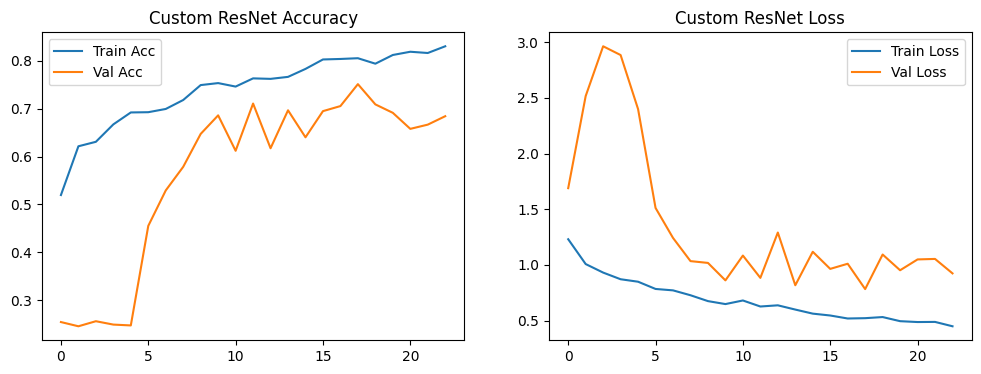

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7268 - loss: 0.7933
Custom ResNet Test Accuracy: 71.09%


In [14]:
# %%
# ---------- TASK 1.5: Custom ResNet ----------

def residual_block(x, filters, stride=1):
    shortcut = x
    
    # First Conv
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Second Conv
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut path:
   
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add the shortcut to the main path
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_custom_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Conv
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2) # Downsample
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2) # Downsample
    x = residual_block(x, 256)
    
    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs, name="Custom_ResNet")

model_resnet_custom = build_custom_resnet((*IMG_SIZE, 3), num_classes)

model_resnet_custom.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy'])

history_resnet_custom = model_resnet_custom.fit(train_ds, 
                                                validation_data=val_ds, 
                                                epochs=30, 
                                                callbacks=callbacks)

# %%
plot_metrics(history_resnet_custom, "Custom ResNet")

test_loss, test_acc = model_resnet_custom.evaluate(test_ds)
print(f"Custom ResNet Test Accuracy: {test_acc*100:.2f}%")

# PRETAINED RESNET50

Found 2746 files belonging to 5 classes.
Using 1923 files for training.
Found 2746 files belonging to 5 classes.
Using 823 files for validation.
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.2580 - loss: 2.1667
Epoch 1: val_accuracy did not improve from 0.87302
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.2584 - loss: 2.1642 - val_accuracy: 0.4868 - val_loss: 1.2738 - learning_rate: 1.0000e-04
Epoch 2/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4001 - loss: 1.6266
Epoch 2: val_accuracy did not improve from 0.87302
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.4001 - loss: 1.6255 - val_accuracy: 0.6402 - val_loss: 0.9514 - learning_rate: 1.0000e-04
Epoch 3/30
60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5025 - loss: 1.3161
Epoch 3: val_accuracy did not improve from 0.87302
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.5025 - loss: 1.3148 - val_accuracy: 0.7196 - val_loss: 0.7731 - learning_rate: 1.0000e-04
Epoch 

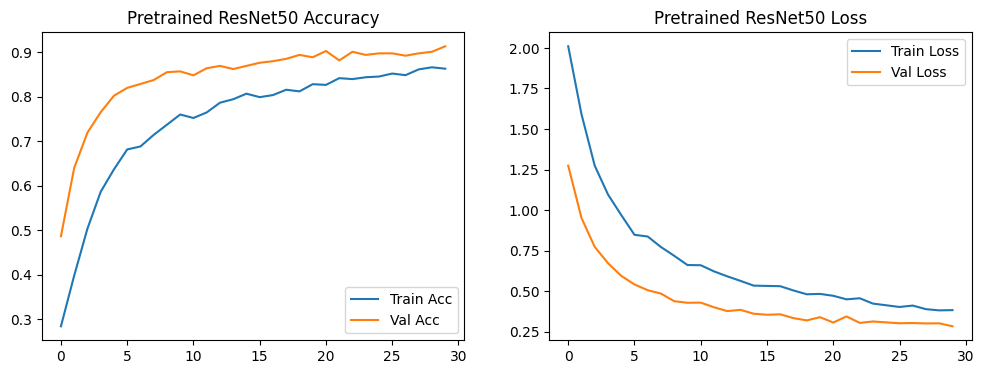

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8714 - loss: 0.3282
Pretrained ResNet50 Test Accuracy: 88.28%


In [16]:

# PART B: PRETRAINED RESNET50 

from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.3, subset="training", seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
valtest_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.3, subset="validation", seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

valtest_batches = tf.data.experimental.cardinality(valtest_ds).numpy()
test_ds = valtest_ds.take(valtest_batches // 3)
val_ds = valtest_ds.skip(valtest_batches // 3)


data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


def apply_resnet_preprocessing(x, y):
    return preprocess_input(x), y

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(apply_resnet_preprocessing) # Apply special norm here
val_ds = val_ds.map(apply_resnet_preprocessing)
test_ds = test_ds.map(apply_resnet_preprocessing)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# 3. LOAD PRETRAINED MODEL
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # Freeze weights

inputs = layers.Input(shape=(*IMG_SIZE, 3))

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_resnet50 = models.Model(inputs, outputs, name="Pretrained_ResNet50")

# 4. TRAIN
model_resnet50.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_resnet50 = model_resnet50.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)

# Plot and Evaluate
plot_metrics(history_resnet50, "Pretrained ResNet50")
test_loss, test_acc = model_resnet50.evaluate(test_ds)
print(f"Pretrained ResNet50 Test Accuracy: {test_acc*100:.2f}%")
